<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/4.%20EDA/EAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt

# scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline

In [11]:
# Adjust the display settings to increase the width
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)  # Do not wrap DataFrame horizontally
pd.set_option('display.width', 240)  # Set the maximum width of the display

In [12]:
!wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/features.csv' -O features.csv
!wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/targets.csv' -O targets.csv

--2024-04-22 20:36:07--  https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146525 (143K) [text/plain]
Saving to: ‘features.csv’

features.csv        100%[===================>] 143.09K  --.-KB/s    in 0.009s  

2024-04-22 20:36:07 (16.3 MB/s) - ‘features.csv’ saved [146525/146525]

--2024-04-22 20:36:07--  https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/targets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [13]:
# Load the downloaded CSV files into pandas DataFrames
features = pd.read_csv('features.csv')
targets = pd.read_csv('targets.csv')

In [14]:
print(features.head())
print(targets.head())

     Age   BMI     Sex  Height  Weight  Length_of_Stay  Alvarado_Score  Paedriatic_Appendicitis_Score Appendix_on_US  Appendix_Diameter Migratory_Pain Lower_Right_Abd_Pain Contralateral_Rebound_Tenderness Coughing_Pain Nausea Loss_of_Appetite  Body_Temperature  WBC_Count  Neutrophil_Percentage  Segmented_Neutrophils Neutrophilia  RBC_Count  Hemoglobin   RDW  Thrombocyte_Count Ketones_in_Urine RBC_in_Urine WBC_in_Urine  CRP Dysuria         Stool Peritonitis Psoas_Sign Ipsilateral_Rebound_Tenderness US_Performed Free_Fluids Appendix_Wall_Layers Target_Sign Appendicolith Perfusion Perforation Surrounding_Tissue_Reaction Appendicular_Abscess Abscess_Location Pathological_Lymph_Nodes Lymph_Nodes_Location Bowel_Wall_Thickening Conglomerate_of_Bowel_Loops Ileus Coprostasis Meteorism Enteritis Gynecological_Findings
0  12.68  16.9  female   148.0    37.0             3.0             4.0                            3.0            yes                7.1             no                  yes         

In [15]:
# Convert categorical variable into dummy/indicator variables (one-hot encoding)
X = pd.get_dummies(features)

# Store feature names after one-hot encoding, as they will be needed for interpreting the model's feature importances
feature_names = X.columns.tolist()

# Assign the encoded diagnosis column to y, which serves as the target variable for the model
y = targets['Diagnosis_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure the same set of columns in both train and test sets
# - 'join=left' ensures all columns in X_train are kept, aligning X_test to it
# - 'axis=1' specifies that the alignment is to be done on columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

IMPUTER

In [16]:
# Create an imputer object that replaces NaN values with the median of the column
imputer = SimpleImputer(strategy='median')

# Standardize the data
scaler = StandardScaler()

RANDOM FOREST

In [17]:
# Create a RandomForestClassifier with a specified number of estimators and a fixed random state for reproducibility
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a pipeline that first imputes missing values then trains a model
pipeline = Pipeline(steps=[('imputer', imputer), ('scaler', scaler), ('classifier', rf_model)])

# Fit the model using the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

FEATURE IMPORTANCE

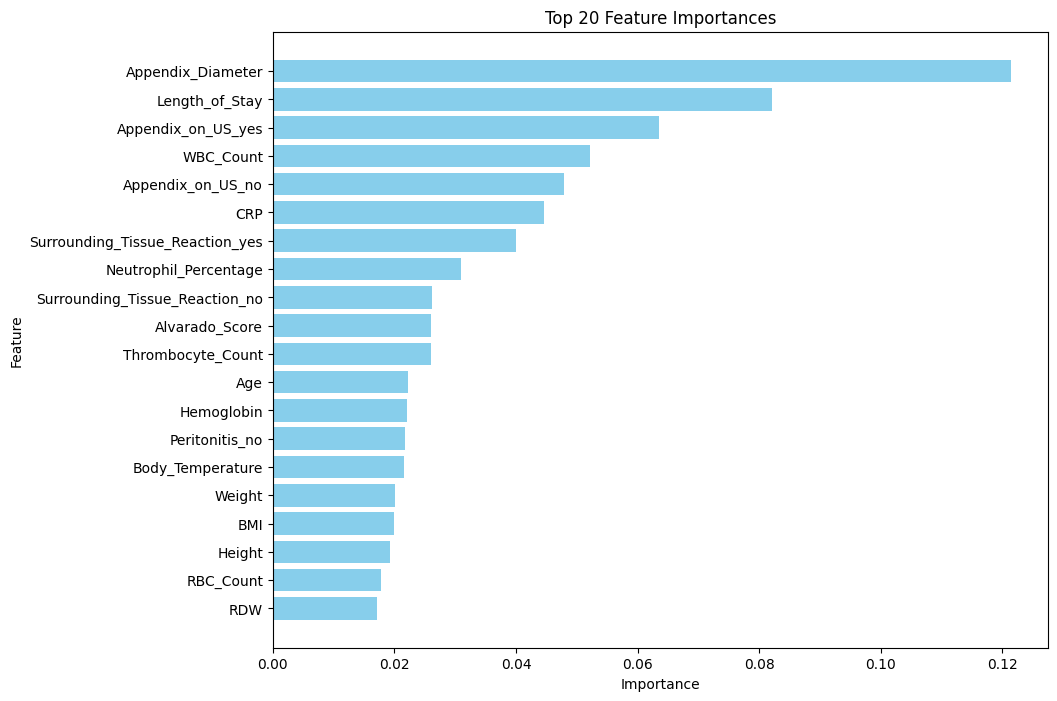

In [18]:
# Get feature importances
importances = rf_model.feature_importances_

# Convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='skyblue')  # top 20 features
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # highest importance at the top
plt.show()
